In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

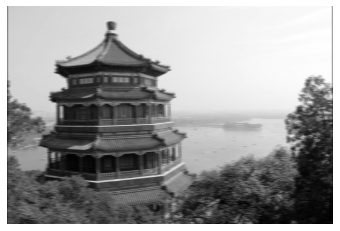

In [3]:
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
plt.imshow(outputs[0, :, :, 1], cmap="gray")
plt.axis("off")
plt.show()

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

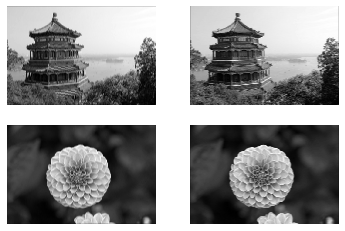

In [5]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [6]:
def crop(images):
  return images[150:220, 130:250]

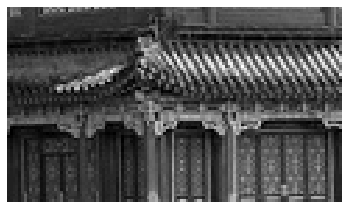

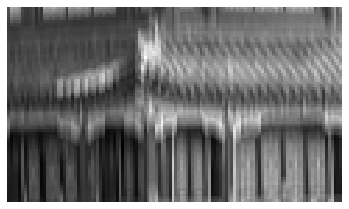

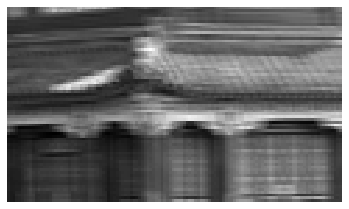

In [7]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

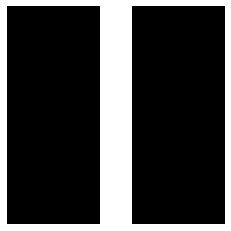

In [8]:
plot_image(filters[:, :, 0, 0])
plt.show()

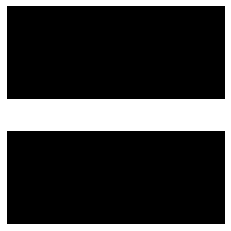

In [9]:
plot_image(filters[:, :, 0, 1])
plt.show()

In [10]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

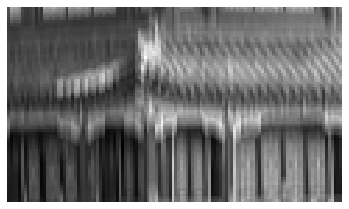

In [11]:
plot_image(crop(outputs[0, :, :, 0]))
plt.show()

In [12]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 1s 0us/step


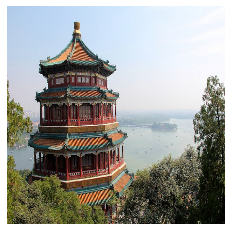

In [13]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

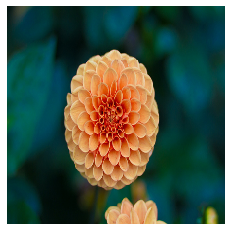

In [14]:
plot_color_image(images_resized[1])
plt.show()

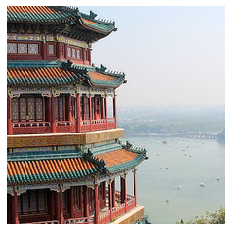

In [15]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

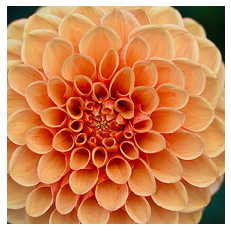

In [16]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[1])
plt.show()

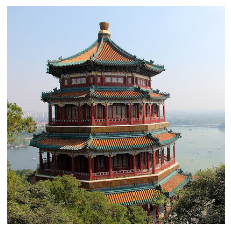

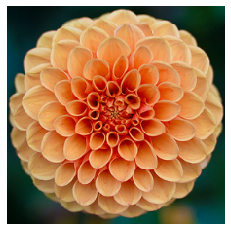

In [17]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [18]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [19]:
Y_proba.shape

(2, 1000)

In [21]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
  print("image #{}".format(image_index))
  for class_id, name, y_proba in top_K[image_index]:
    print(" {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
  print()

image #0
 n03877845 - palace       43.39%
 n02825657 - bell_cote    43.07%
 n03781244 - monastery    11.70%

image #1
 n04522168 - vase         53.96%
 n07930864 - cup          9.52%
 n11939491 - daisy        4.97%



In [22]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


In [23]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [24]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=3670>

In [26]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [27]:
n_classes = info.features["label"].num_classes

In [28]:
n_classes

5

In [29]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [30]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True
)

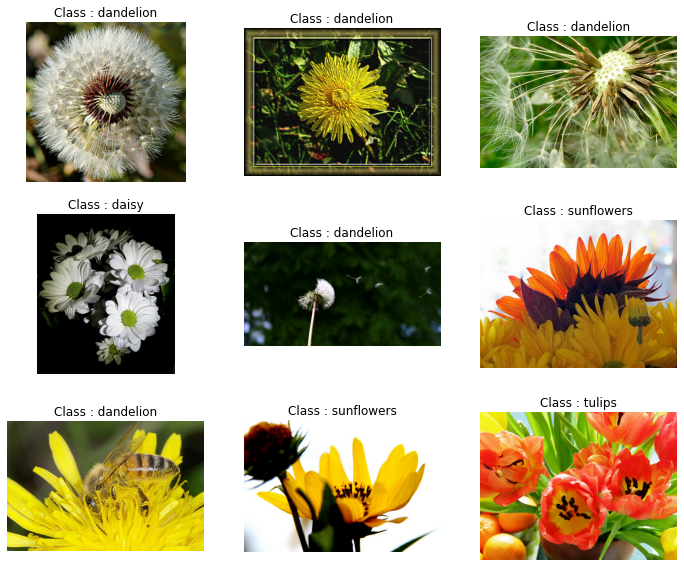

In [32]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
  index += 1
  plt.subplot(3, 3, index)
  plt.imshow(image)
  plt.title("Class : {}".format(class_names[label]))
  plt.axis("off")


In [34]:
def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  final_image = keras.applications.resnet50.preprocess_input(resized_image)
  return final_iamge, label

In [49]:
from  functools import partial

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
  shape = tf.shape(image)
  min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
  return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
  if randomize:
    cropped_image = random_crop(image)
    cropped_image = tf.image.random_flip_left_right(cropped_image)
  else:
    cropped_image = central_crop(image)
  resized_image = tf.image.resize(cropped_image, [224, 224])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

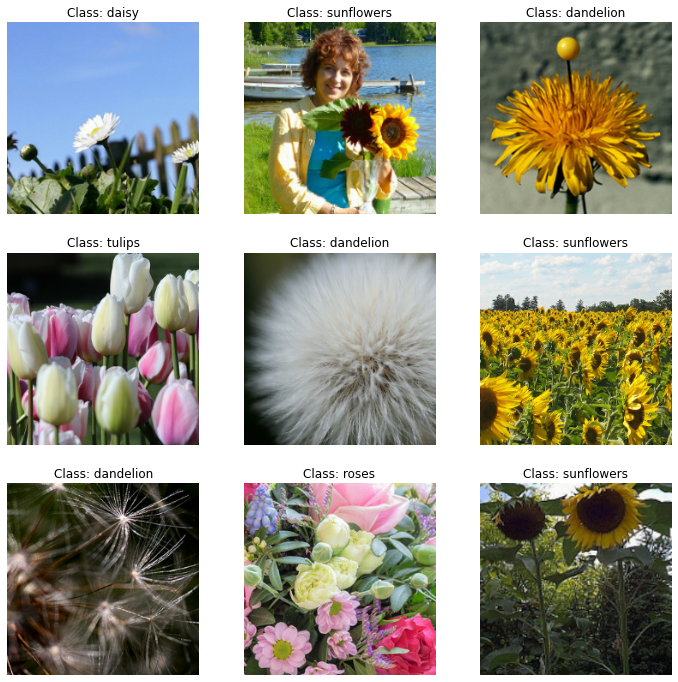

In [51]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [56]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [57]:
for index, layer in enumerate(base_model.layers):
  print(index, layer.name)

0 input_6
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_17
13 block2_pool
14 batch_normalization_16
15 add_48
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_18
23 block3_pool
24 batch_normalization_17
25 add_49
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_19
33 block4_pool
34 batch_normalization_18
35 add_50
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_51
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 blo

In [58]:
for layer in base_model.layers:
  layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 14s 159ms/step - loss: 1.2910 - accuracy: 0.8034 - val_loss: 0.8702 - val_accuracy: 0.8768
Epoch 2/5
86/86 [==============================] - 13s 153ms/step - loss: 0.5176 - accuracy: 0.9001 - val_loss: 0.9246 - val_accuracy: 0.8713
Epoch 3/5
86/86 [==============================] - 13s 156ms/step - loss: 0.3385 - accuracy: 0.9193 - val_loss: 0.7750 - val_accuracy: 0.8658
Epoch 4/5
86/86 [==============================] - 13s 156ms/step - loss: 0.2471 - accuracy: 0.9390 - val_loss: 0.7715 - val_accuracy: 0.8658
Epoch 5/5
86/86 [==============================] - 13s 156ms/step - loss: 0.2081 - accuracy: 0.9480 - val_loss: 0.6577 - val_accuracy: 0.8768


In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
 2/86 [..............................] - ETA: 22s - loss: 0.6586 - accuracy: 0.8281WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1425s vs `on_train_batch_end` time: 0.4045s). Check your callbacks.


76/86 [=========================>....] - ETA: 5s - loss: 0.3673 - accuracy: 0.8799